##### Author: Krishna Prasanna Bhamidipati (kbhamid2)

In [1]:
!pip install sentence-transformers
!pip install -U textblob

     |████████████████████████████████| 78 kB 2.4 MB/s 
     |████████████████████████████████| 3.1 MB 9.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.6 MB/s 
     |████████████████████████████████| 1.2 MB 55.5 MB/s 
     |████████████████████████████████| 59 kB 3.7 MB/s 
     |████████████████████████████████| 895 kB 47.5 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=b8aebb05c0dc53f8d032a298de7e4f878b8d162cd7bd7053ee1f8bfbf6781d15
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 636 kB 4.0 MB/s 
  Attempting uninstall: textblob
    Found existing installation

In [2]:
#Load the required libraries
import os
import numpy as np
import pandas as pd
import re,string
import nltk

nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob

import sklearn.model_selection as model_selection
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from sentence_transformers import SentenceTransformer #Transformer libraries for sentence embedding generation
import torch

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/CSC791 NATURAL LANGUAGE PROCESSING/


Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/CSC791 NATURAL LANGUAGE PROCESSING


In [4]:
#Import the datasets
data = pd.read_excel('P2 AITA_Combined.xlsx')

In [5]:
context = data[data['id1'].str.match('(t3_*)')]
#Sanity check to ensure only story descriptions are picked up.
context.shape[0] == context['id2'].isna().sum()

print("Actual data shape: ",data.shape[0])

print("There are {} story descrptions and {} back-and-forth arguments \
between challenger and OP".format(context.shape[0],data.shape[0]-context.shape[0]))

data.head()

Actual data shape:  1907
There are 411 story descrptions and 1496 back-and-forth arguments between challenger and OP


,id1,text1,id2,text2,Label 1: argument 2: provide more info regarding the story. 0: neither of both
0,t3_guf4m8,AITA for getting upset when my boyfriend (23M)...,NaN,NaN,NaN
1,t1_fsi2iwj,YTA How was he supposed to know you had switch...,t1_fsi3rgi,He should know.,1.0
2,t1_fsi2zse,"ESH. You, for blowing up on him especially in ...",t1_fsi3r57,"But he's the BIGGER asshole, right?",1.0
3,t1_fsi38kc,"YTA. Firstly, if you don't want to be called i...",t1_fsi3f75,"No, it's not my job to clean the bathroom. He ...",1.0
4,t1_fsi477k,YTA for letting it go on to the point where it...,t1_fsi4jkf,How can he get fired over something like that?,0.0


#### SOME OBSERVATIONS REGARDING THE DATASET (AND ASSOCIATED TASKS):
1. The dataset consists of 1907 rows. Out of these 411 rows correspond to OP's context setting texts.

2. There are 2 ID columns, but it looks like the ID is the identifier for the text rather than the person who created the text. Hence, the OP does not have same ID for all his/ her opinions.
The OP's context text has ID that starts with t3_, whereas the subsequent back and forth arguments between OP and Challenger have IDs starting with t1_. Excepting for a minor feature engineering task, these IDs can be safely deleted.

<font color = 'violet'> Task: </font>
<font color = 'turquoise'>
- Identify and separate context setting texts from regular back-and-forth arguments using the IDs. 
- Append the OP's context text as 'story' for the corresponding arguments that stem from it - either as the text itself, or as subjectivity score.
- The OP's context text will be used in both base-line model as well as proposed model.
- NOTE THAT THIS DOES NOT CONSIDER AS ADDITIONAL FEATURE, IT IS JUST A MANIPULATION OF DATASET TO USE THE STORY DESCRIPTION AS ADDITIONAL INPUT
    </font>
    
3. There are commonly used abbrevations (AITA, ESH, OP).

<font color = 'violet'> Task:</font>
    <font color = 'turquoise'>
- Since words like 'asshole' have a negative sentiment attached to it, expanding such abbreviations may help capture sentiments better. 
- This task is a pre-requisite for generating sentiment-based BERT sentence embeddings
    </font>
    
        
4. Since the language is informal (and also, somewhat offensive but that's okay), there are several instances of clitics in the text.

<font color = 'violet'> Task:</font>
    <font color = 'turquoise'>
- Ideally, clitic replacement is done by tokenizing using WordPiece tokenizer, then reconstructing the sentence using join on the token list. 
- Since we are using the BERT-base word embeddings model, this task can be skipped as the tokenizer used by BERT IS the WordPiece tokenizer.
- One less task to do, hurrah!!!
    </font>

#### Dataset manipulation to use story description as additional input

In [6]:
data['id1'] = data['id1'].apply(lambda x: x if 't3_' in x else None).ffill()
data = data.merge(context[['id1','text1']], on = 'id1').reset_index(drop = True).rename(columns = {'text1_x':'text1','text1_y':'story'})
## Drop the rows with only story-text
data.dropna(subset = ['text2'],inplace = True)


#There were a couple of rows, which were the challenger-op pairs, but they did not have any label marked to them. Replacing them with 0.  

print('NAs in the dataset')
print(data.isna().sum())
data.fillna(0,inplace = True)

data.head()

NAs in the dataset
id1                                                                               0
text1                                                                             0
id2                                                                               0
text2                                                                             0
Label 1: argument 2: provide more info regarding the story. 0: neither of both    2
story                                                                             0
dtype: int64


,id1,text1,id2,text2,Label 1: argument 2: provide more info regarding the story. 0: neither of both,story
1,t3_guf4m8,YTA How was he supposed to know you had switch...,t1_fsi3rgi,He should know.,1.0,AITA for getting upset when my boyfriend (23M)...
2,t3_guf4m8,"ESH. You, for blowing up on him especially in ...",t1_fsi3r57,"But he's the BIGGER asshole, right?",1.0,AITA for getting upset when my boyfriend (23M)...
3,t3_guf4m8,"YTA. Firstly, if you don't want to be called i...",t1_fsi3f75,"No, it's not my job to clean the bathroom. He ...",1.0,AITA for getting upset when my boyfriend (23M)...
4,t3_guf4m8,YTA for letting it go on to the point where it...,t1_fsi4jkf,How can he get fired over something like that?,0.0,AITA for getting upset when my boyfriend (23M)...
5,t3_guf4m8,YTA: it really sounds like you’re over your bo...,t1_fur89em,I don't want to leave him. I love him.,0.0,AITA for getting upset when my boyfriend (23M)...


#### Abbreviation replacement, then removing the IDs 1 and 2, and finally separating out labels as the y-column

In [7]:
#Get a list of all abbreviations in the text. Replace those abbrevations:
abbr_replacements = {'YTA':'You are the asshole.','NTA':'You are not the asshole.','AITA':'Am I the asshole','Ahole':'asshole','AH':'asshole',\
                     'WIBTA':'Would I be the asshole','ESH':'Everyone sucks here.','OP':'Opinion provider','ahole':'asshole'}

for key,value in abbr_replacements.items():
    data['text1'] = data['text1'].apply(lambda r: re.sub(key,value, str(r)))
    data['text2'] = data['text2'].apply(lambda r: re.sub(key,value, str(r)))
    data['story'] = data['story'].apply(lambda r: re.sub(key,value, str(r)))
    
#Just removing all the extra full-stops. 
data['text1'] = data['text1'].apply(lambda r: re.sub(r'\.+','.', str(r)))
data['text2'] = data['text2'].apply(lambda r: re.sub(r'\.+','.', str(r)))
data['story'] = data['story'].apply(lambda r: re.sub(r'\.+','.', str(r)))
data['text1'] = data['text1'].apply(lambda r: re.sub(r'\:','', str(r)))
data['text2'] = data['text2'].apply(lambda r: re.sub(r'\:','', str(r)))
data['story'] = data['story'].apply(lambda r: re.sub(r'\:','', str(r)))
    
    
data.drop(['id1','id2'], axis = 1, inplace = True)

print('Final data shape:',data.shape)
data.head()

Final data shape: (1496, 4)


,text1,text2,Label 1: argument 2: provide more info regarding the story. 0: neither of both,story
1,You are the asshole. How was he supposed to kn...,He should know.,1.0,Am I the asshole for getting upset when my boy...
2,"Everyone sucks here. You, for blowing up on hi...","But he's the BIGGER asshole, right?",1.0,Am I the asshole for getting upset when my boy...
3,"You are the asshole. Firstly, if you don't wan...","No, it's not my job to clean the bathroom. He ...",1.0,Am I the asshole for getting upset when my boy...
4,You are the asshole. for letting it go on to t...,How can he get fired over something like that?,0.0,Am I the asshole for getting upset when my boy...
5,You are the asshole. it really sounds like you...,I don't want to leave him. I love him.,0.0,Am I the asshole for getting upset when my boy...


In [8]:
labels = data.pop('Label 1: argument 2: provide more info regarding the story. 0: neither of both')

#### BERT-based Sentence Embeddings
- For generating sentence embeddings there are two ways:

<font color = 'violet'>   
1. Perform tokenization with word-piece, generate word-level embeddings using BERT's pre-trained model and average them out to get sentence level embeddings.  </font>
 
<font color = 'violet'> 
2. Use SBERT to generate sentence embeddings. SBERT uses a different architecture that works well for semantically similar sentences as well. This paper discusses further in detail how SBERT generates better sentence embeddings over regular BERT's averaged-embeddings (https://arxiv.org/pdf/1908.10084.pdf)
 </font>
 
- For this project, SBERT has been implemented by using the Hugging-Face's transformers library function SentenceTransformer. 
- Three SBERT embeddings are generated for text1, text2 and story sentences. Then a single embedding vector is generated by taking a weighted average for these embeddings.
- These embeddings are fed as a feature to multi-class SVM classifier.

In [9]:
# Load auto-models from HuggingFace Hub
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Tokenize pairs of sentences together
# encoded_input = tokenizer(list(data['text1'].values),list(data['text2'].values), padding=True, truncation=True, max_length= 400, return_tensors='pt')
encoded_input_text1 = model.encode(list(data['text1'].values))
encoded_input_text2 = model.encode(list(data['text2'].values))
encoded_input_text3 = model.encode(list(data['story'].values))

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### BASELINE MODEL
The base-line model used for this task is SVM multi-class classifier. The sentence embeddings ( sized vector) will be the training algorithm. performance of linear and rbf kernels has been compared. 

<font color = 'orange'/>
The model has been tested out against different combinations of the three available features - text1, text2 and story.
</font>
<font color = 'turquoise'/>

- Combination 1: Using only OP's defense argument with weights (0,1,0)
-  Combination 2: Using all three text inputs with weights (0.2,0.4,0.4)
- Combination 3: Using OP's defense argument and story (0,0.5,0.5)
-  Combination 4: Using all three text inputs with weights (-0.2,0.6,0.6)
</font>

In [10]:
#Generated weighted average of embeddings:
#Combination 1:
weighted_embeddings_1 = encoded_input_text2

#Combination 2:
weighted_embeddings_2 =  0.2 * encoded_input_text1 + 0.4 * encoded_input_text2 + 0.4 * encoded_input_text3  

#Combination 3:
weighted_embeddings_3 =  0.5 * encoded_input_text2 + 0.5 * encoded_input_text3

#Combination 4:
weighted_embeddings_4 =  -0.2 * encoded_input_text1 + 0.6 * encoded_input_text2 + 0.6 * encoded_input_text3

#### Baseline model definition and implementations.

In [11]:
def model_for_combination(weighted_embeddings,labels):
  # Train-test split
  X_train, X_test, y_train, y_test = model_selection.train_test_split(weighted_embeddings, labels, train_size=0.75, test_size=0.25, random_state=124)

  # Model training
  linear = svm.SVC(kernel='linear', gamma=0.7, C=0.05).fit(X_train, y_train)
  poly = svm.SVC(kernel='poly', gamma=0.7, C=0.05).fit(X_train, y_train)

  # Model testing
  lin_pred = linear.predict(X_test)
  poly_pred = poly.predict(X_test)

  #Print classification reports
  print("Classification report for linear SVM:")
  lin_report = classification_report(y_test, lin_pred)
  print(lin_report)
  print("*"*50)

  print("Classification report for polynomial SVM:")
  poly_report = classification_report(y_test, poly_pred)
  print(poly_report)
  print("*"*50)


In [12]:
print('RESULTS FOR COMBINATION 1')
model_for_combination(weighted_embeddings_1,labels)
print("*" * 50)
print('RESULTS FOR COMBINATION 2')
model_for_combination(weighted_embeddings_2,labels)
print("*" * 50)
print('RESULTS FOR COMBINATION 3')
model_for_combination(weighted_embeddings_3,labels)
print("*" * 50)
print('RESULTS FOR COMBINATION 4')
model_for_combination(weighted_embeddings_4,labels)
print("*" * 50)

RESULTS FOR COMBINATION 1
Classification report for linear SVM:
              precision    recall  f1-score   support

         0.0       0.66      0.61      0.63        96
         1.0       0.60      0.74      0.66       161
         2.0       0.61      0.45      0.52       117

    accuracy                           0.62       374
   macro avg       0.62      0.60      0.61       374
weighted avg       0.62      0.62      0.61       374

**************************************************
Classification report for polynomial SVM:
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.60        96
         1.0       0.61      0.71      0.66       161
         2.0       0.62      0.43      0.51       117

    accuracy                           0.60       374
   macro avg       0.60      0.59      0.59       374
weighted avg       0.60      0.60      0.60       374

**************************************************
******************************

<font color = 'violet'> The model seems to have best accuracy score for linear SVM for combination 1 and polynomial SVM for combination 4.

Baseline model's accuracy for SVM classifier is about 62%.
</font>

#### PROPOSED MODEL
The following changes have been made to improve the scores of base-line model - 
1. Additional features: Different features have been engineered from available text data-fields. Some of the additional features tried out were-
- <font color = 'turquoise'> Subjectivity score - Subjectivity score in textblob library gives the score of how subjective a particular piece of text is, by accounting for emotions/personal opinions vs facts. It gives a score between 0 and 1, where 0 indicates very objective and 1 indicates very subjective.
- Count of pronouns: The count of distinct pronouns in challenger's has been considered here as final additional feature. My hypothesis is that many ESH statements have mentions of 2 or more pronouns because the challenger must explain why everyone is at fault. 
Of course, for testing my hypothesis I have used both challenger's as well as OP's distinct pronoun counts and checked which gave a better accuracy. 
- Polarity score - Polarity score in textblob library gives the score of sentence polarity (positive or negative). 
</font>

<font color = 'orange'>
NOTE: Statistical measures and box-plots have been used to select the best 2 additional features that may improve model performance.
</font>

2. Model: To maintain a fair comparison of performance by inclusion of additional features, SVM classifier has been used to perform the desired multi-class classification. 


In [13]:
#User defined functions
def get_pronoun_count(row):
  count = 0
  for i in row:
    if (i and i[1] == 'PRP'):
      count +=1
  return count
  
#Getting the unique pronouns from sentences and appending as feature:
add_feature_df = pd.DataFrame()
add_feature_df['text1_unique_words'] = data.apply(lambda row: list(set(row['text1'].lower().split())), axis=1)
add_feature_df['text2_unique_words'] = data.apply(lambda row: list(set(row['text2'].lower().split())), axis=1)

add_feature_df['text1_pos_tags'] = add_feature_df.apply(lambda row: nltk.pos_tag(row['text1_unique_words']), axis=1)
add_feature_df['text2_pos_tags'] = add_feature_df.apply(lambda row: nltk.pos_tag(row['text2_unique_words']), axis=1)

add_feature_df['text1_pronoun_count'] = add_feature_df['text1_pos_tags'].map(lambda x: get_pronoun_count(x))
add_feature_df['text2_pronoun_count'] = add_feature_df['text2_pos_tags'].map(lambda x: get_pronoun_count(x))

add_feature_df.fillna(0, inplace = True)

#Adding subjectivity score of OP's response as one of the features:
add_feature_df['subjectivity_OP'] = data['text2'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

#Adding polarity score of Challenger's response as one of the features:
add_feature_df['polarity_challenger'] = data['text1'].apply(lambda x: TextBlob(x).sentiment.polarity)

#Adding even the labels to this data-set (for easier box-plots)
add_feature_df['labels'] = labels
add_feature_df['labels'] = add_feature_df['labels'].astype(str)

print(add_feature_df.shape)
add_feature_df.head()

(1496, 9)


,text1_unique_words,text2_unique_words,text1_pos_tags,text2_pos_tags,text1_pronoun_count,text2_pronoun_count,subjectivity_OP,polarity_challenger,labels
1,"[the, was, thinking, switched, how, to, cute, ...","[he, know., should]","[(the, DT), (was, VBD), (thinking, VBG), (swit...","[(he, PRP), (know., VBD), (should, MD)]",2,1,0.000000,0.500000,1.0
2,"[up, here., started, probably, conversation, t...","[the, but, right?, he's, bigger, asshole,]","[(up, RB), (here., NN), (started, VBD), (proba...","[(the, DT), (but, CC), (right?, JJ), (he's, NN...",3,0,0.517857,-0.262500,1.0
3,"[the, tantrum., to, that, firstly,, don't, sor...","[the, to, stays, no,, have, my, it's, job, so,...","[(the, DT), (tantrum., NN), (to, TO), (that, D...","[(the, DT), (to, TO), (stays, VB), (no,, RB), ...",3,1,0.650000,0.263333,1.0
4,"[speech., that, madness., it.verily,, was, wor...","[something, how, that?, like, he, get, fired, ...","[(speech., NN), (that, WDT), (madness., VBD), ...","[(something, NN), (how, WRB), (that?, NN), (li...",4,1,0.000000,-0.346528,0.0
5,"[the, probably, turns, how, don’t, to, that, b...","[to, don't, him., i, want, love, leave]","[(the, DT), (probably, RB), (turns, VBZ), (how...","[(to, TO), (don't, VB), (him., NN), (i, NN), (...",5,0,0.600000,0.035714,0.0


#### Selecting additional features using box-plots and statistical distributions. 
<font color = 'violet'> Task</font>
<font color = 'turquoise'>

- In the following cell, we plot box-plots to identify which 'additional variable' is likely to explain our 'labels' better. 
- We plot these additional variables against labels to visualize the range of these variables for each label group. 
- Whichever additional features have 'distinguishable' range wrt label groups, we select those.
</font>

Text(0.5, 1.0, "Distribution of polarity score of challenger's response wrt labels")

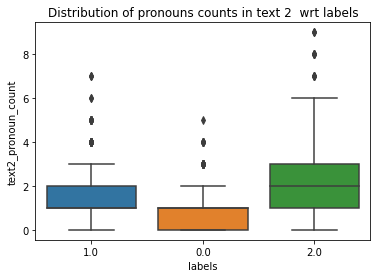

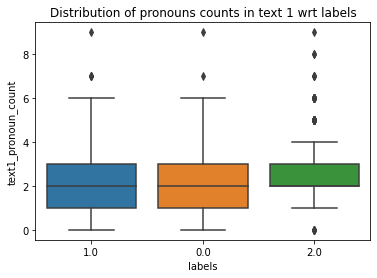

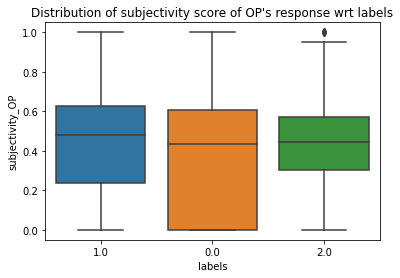

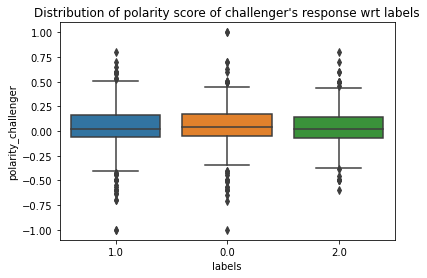

In [14]:
#Creating a box-plot to check if there is a good demarkation of additional quantitative features wrt labels
# Creating plot
plt.figure()
sns.boxplot(x='labels', y="text2_pronoun_count", data=add_feature_df).set_title("Distribution of pronouns counts in text 2  wrt labels")
plt.figure()
sns.boxplot(x='labels', y="text1_pronoun_count", data=add_feature_df).set_title("Distribution of pronouns counts in text 1 wrt labels")
plt.figure()
sns.boxplot(x='labels', y="subjectivity_OP", data=add_feature_df).set_title("Distribution of subjectivity score of OP's response wrt labels")
plt.figure()
sns.boxplot(x='labels', y="polarity_challenger", data=add_feature_df).set_title("Distribution of polarity score of challenger's response wrt labels")

#### Proposed model definition and implementations

In [15]:
def proposed_model_for_combination(weighted_embeddings,labels,pos_df):

  #Appending new features to existing embeddings. The number of features are now 768+2 = 770 features.
  extended_embeddings =  list(weighted_embeddings)
  for i in range(len(extended_embeddings)):
    extended_embeddings[i] = list(extended_embeddings[i])
    extended_embeddings[i].append(pos_df['subjectivity_OP'].values[i])
    extended_embeddings[i].append(pos_df['text2_pronoun_count'].values[i])
    
  #Converting to numpy array to feed into the model
  extended_embeddings = np.asarray(extended_embeddings)

  print(extended_embeddings.shape)

  
  # Train-test split
  X_train, X_test, y_train, y_test = model_selection.train_test_split(extended_embeddings, labels, train_size=0.75, test_size=0.25, random_state=124)

  # Model training
  linear = svm.SVC(kernel='linear', gamma=0.7, C=0.05).fit(X_train, y_train)
  poly = svm.SVC(kernel='poly', gamma=0.7, C=0.05).fit(X_train, y_train)

  # Model testing
  lin_pred = linear.predict(X_test)
  poly_pred = poly.predict(X_test)

  #Print classification reports
  print("Classification report for linear SVM:")
  lin_report = classification_report(y_test, lin_pred)
  print(lin_report)
  print("*"*50)

  print("Classification report for polynomial SVM:")
  poly_report = classification_report(y_test, poly_pred)
  print(poly_report)
  print("*"*50)


In [16]:
print('RESULTS FOR COMBINATION 1')
proposed_model_for_combination(weighted_embeddings_1,labels,add_feature_df)
print("*" * 50)
print('RESULTS FOR COMBINATION 2')
proposed_model_for_combination(weighted_embeddings_2,labels,add_feature_df)
print("*" * 50)
print('RESULTS FOR COMBINATION 3')
proposed_model_for_combination(weighted_embeddings_3,labels,add_feature_df)
print("*" * 50)
print('RESULTS FOR COMBINATION 4')
proposed_model_for_combination(weighted_embeddings_4,labels,add_feature_df)
print("*" * 50)

RESULTS FOR COMBINATION 1
(1496, 770)
Classification report for linear SVM:
              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62        96
         1.0       0.60      0.73      0.66       161
         2.0       0.61      0.45      0.52       117

    accuracy                           0.61       374
   macro avg       0.61      0.59      0.60       374
weighted avg       0.61      0.61      0.60       374

**************************************************
Classification report for polynomial SVM:
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.62        96
         1.0       0.61      0.71      0.66       161
         2.0       0.63      0.44      0.52       117

    accuracy                           0.61       374
   macro avg       0.61      0.60      0.60       374
weighted avg       0.61      0.61      0.60       374

**************************************************
******************